In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio  # For creating GIFs
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# -------------------------------
# Set seeds and device
# -------------------------------
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


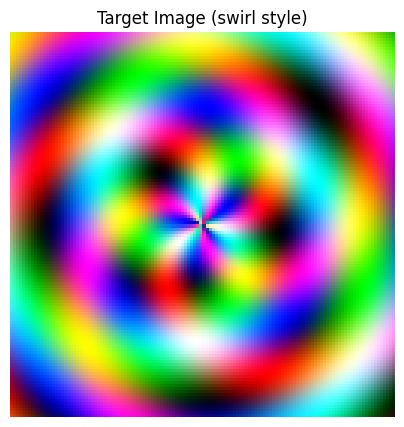

In [3]:
# -------------------------------
# Step 1. Generate a Target Abstract Image
# -------------------------------
def generate_target_image(resolution=128, style='swirl'):
    """
    Generate an abstract target image using various styles.
    
    Args:
        resolution: Image resolution (width and height)
        style: Type of pattern to generate ('swirl', 'waves', 'fractal')
    
    Returns:
        RGB image array of shape (resolution, resolution, 3)
    """
    x = np.linspace(-1, 1, resolution)
    y = np.linspace(-1, 1, resolution)
    xv, yv = np.meshgrid(x, y)
    r = np.sqrt(xv**2 + yv**2)
    theta = np.arctan2(yv, xv)
    
    if style == 'swirl':
        R = (np.sin(5 * theta + r * 10) + 1) / 2
        G = (np.cos(3 * theta - r * 8) + 1) / 2
        B = (np.sin(4 * r * np.pi) + 1) / 2
    elif style == 'waves':
        R = (np.sin(xv * 5) + 1) / 2
        G = (np.sin(yv * 5 + 2) + 1) / 2
        B = (np.cos(xv * 3 + yv * 3) + 1) / 2
    elif style == 'fractal':
        R = (np.sin(10 * r) * np.cos(5 * theta) + 1) / 2
        G = (np.cos(8 * r) * np.sin(4 * theta) + 1) / 2
        B = (np.sin(6 * r + 3 * theta) + 1) / 2
    else:
        raise ValueError(f"Unknown style: {style}")
        
    target = np.stack([R, G, B], axis=-1)
    return target

# Set resolution and generate target image
resolution = 128
image_style = 'swirl'  # Options: 'swirl', 'waves', or 'fractal'
target_image = generate_target_image(resolution, style=image_style)

# Display target image
plt.figure(figsize=(5, 5))
plt.imshow(target_image)
plt.title(f"Target Image ({image_style} style)")
plt.axis("off")
plt.show()


In [4]:
# -------------------------------
# Step 2. Prepare Training Data
# -------------------------------
x = np.linspace(-1, 1, resolution)
y = np.linspace(-1, 1, resolution)
xv, yv = np.meshgrid(x, y)
coords = np.stack([xv, yv], axis=-1).reshape(-1, 2)
target_pixels = target_image.reshape(-1, 3)

# Convert to torch tensors
coords_tensor = torch.tensor(coords, dtype=torch.float32, device=device)
target_tensor = torch.tensor(target_pixels, dtype=torch.float32, device=device)


In [5]:
# -------------------------------
# Step 3. Positional Encoding
# -------------------------------
def positional_encoding(x, num_encoding_functions=10, include_input=True):
    """
    Apply positional encoding to the input tensor x.
    
    Args:
        x: Input tensor to encode
        num_encoding_functions: Number of frequency bands
        include_input: Whether to include the input in the encoding
    
    Returns:
        Encoded tensor with shape (batch_size, in_features * (2 * num_encoding_functions + 1))
    """
    encodings = [x] if include_input else []
    for i in range(num_encoding_functions):
        freq = 2.0 ** i
        for fn in [torch.sin, torch.cos]:
            encodings.append(fn(freq * np.pi * x))
    return torch.cat(encodings, dim=-1)

# Apply positional encoding
num_encoding_functions = 8
coords_encoded = positional_encoding(coords_tensor, num_encoding_functions)

# Create DataLoader
batch_size = 4096  # Adjust according to available GPU memory
dataset = TensorDataset(coords_encoded, target_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [6]:
# -------------------------------
# Step 4. Define the Neural Network Model
# -------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LeakyReLU(0.2),
            nn.Linear(dim, dim)
        )
        
    def forward(self, x):
        return x + self.net(x)

class ImprovedImageMLP(nn.Module):
    def __init__(self, in_features, hidden_dim=256, num_hidden_layers=4, num_res_blocks=3):
        super(ImprovedImageMLP, self).__init__()
        layers = [nn.Linear(in_features, hidden_dim), nn.LeakyReLU(0.2)]
        
        # Add residual blocks
        for _ in range(num_res_blocks):
            layers.append(ResidualBlock(hidden_dim))
            layers.append(nn.LeakyReLU(0.2))
        
        # Additional hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LeakyReLU(0.2))
        
        # Output layer (RGB)
        layers.append(nn.Linear(hidden_dim, 3))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Create model instance
in_features = coords_encoded.shape[1]
model = ImprovedImageMLP(
    in_features=in_features,
    hidden_dim=256,
    num_hidden_layers=4,
    num_res_blocks=3
).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Loss function
loss_fn = nn.MSELoss()


Model parameters: 601859


In [7]:
# -------------------------------
# Step 5. Reinforcement Learning Setup for Learning Rate Selection
# -------------------------------
lr_candidates = [0.0005, 0.001, 0.002]
Q_values = {lr: 0.0 for lr in lr_candidates}
counts = {lr: 0 for lr in lr_candidates}
epsilon = 0.2  # Exploration rate for epsilon-greedy
alpha_rl = 0.1  # RL learning rate for Q-value updates

def choose_learning_rate():
    """Choose a learning rate using an epsilon-greedy strategy."""
    if np.random.rand() < epsilon:
        lr = np.random.choice(lr_candidates)
    else:
        lr = max(Q_values, key=Q_values.get)
    return lr

def update_Q(chosen_lr, reward):
    """Update the Q-value for the chosen learning rate."""
    counts[chosen_lr] += 1
    Q_values[chosen_lr] += alpha_rl * (reward - Q_values[chosen_lr])


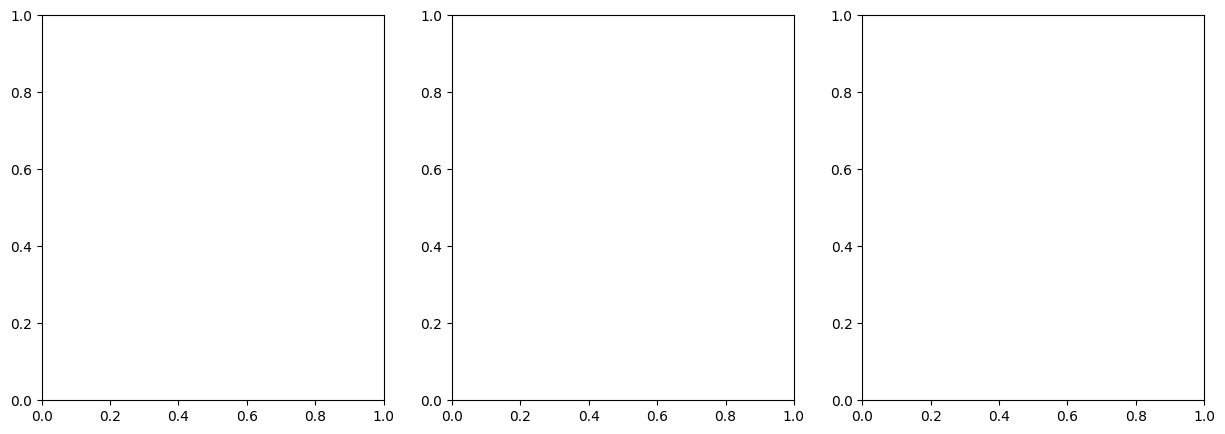

In [8]:
# -------------------------------
# Step 6. Setup for Saving Epoch Images and Accuracy Logging
# -------------------------------
save_folder = "epoch_images"
os.makedirs(save_folder, exist_ok=True)

loss_history = []
accuracy_history = []
lr_history = []
reward_history = []
tolerance = 0.1  # Tolerance for accuracy metric

plt.ion()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
generated_images = []  # For storing images during training

def compute_accuracy(gen, target, tol=tolerance):
    """
    Compute the accuracy as the fraction of pixels where all channel differences are below tol.
    """
    diff = np.abs(gen - target)
    correct = np.all(diff < tol, axis=-1)
    return np.mean(correct)

def visualize_progress(epoch, avg_loss, lr, acc):
    axes[0].clear()
    axes[0].plot(loss_history, color='blue')
    axes[0].set_title("Training Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("MSE Loss")
    
    with torch.no_grad():
        gen_image = model(coords_encoded).cpu().numpy()
    gen_image = gen_image.reshape(resolution, resolution, 3)
    generated_images.append((epoch, gen_image.copy()))
    
    axes[1].clear()
    axes[1].imshow(gen_image)
    axes[1].set_title(f"Generated Image (Epoch {epoch})")
    axes[1].axis("off")
    
    axes[2].clear()
    axes[2].imshow(target_image)
    axes[2].set_title("Target Image")
    axes[2].axis("off")
    
    plt.suptitle(f"Epoch {epoch} | Loss: {avg_loss:.6f} | LR: {lr} | Acc: {acc:.3f}")
    plt.tight_layout()
    plt.draw()
    plt.pause(0.5)


In [9]:
# -------------------------------
# Step 7. Training Loop with RL-based LR Selection (100 Epochs)
# -------------------------------
num_epochs = 100
prev_loss = None

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    chosen_lr = choose_learning_rate()
    lr_history.append(chosen_lr)
    
    optimizer = optim.Adam(model.parameters(), lr=chosen_lr, betas=(0.9, 0.999))
    
    epoch_loss = 0
    batches = 0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        batches += 1
    
    avg_loss = epoch_loss / batches
    loss_history.append(avg_loss)
    
    if prev_loss is None:
        reward = 0.0
    else:
        reward = prev_loss - avg_loss
    reward_history.append(reward)
    update_Q(chosen_lr, reward)
    prev_loss = avg_loss
    
    with torch.no_grad():
        gen_image = model(coords_encoded).cpu().numpy().reshape(resolution, resolution, 3)
    acc = compute_accuracy(gen_image, target_image, tol=tolerance)
    accuracy_history.append(acc)
    
    visualize_progress(epoch, avg_loss, chosen_lr, acc)
    
    # Save generated image for first 30 epochs for GIF creation
    if epoch < 30:
        save_path = os.path.join(save_folder, f"epoch_{epoch:02d}.png")
        plt.imsave(save_path, gen_image)
    
    print(f"Epoch {epoch}/{num_epochs-1}, Loss: {avg_loss:.6f}, LR: {chosen_lr}, Reward: {reward:.6f}, Accuracy: {acc:.3f}")

plt.ioff()


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

Training Epochs:   1%|          | 1/100 [00:01<02:20,  1.41s/it]

Epoch 0/99, Loss: 0.123821, LR: 0.0005, Reward: 0.000000, Accuracy: 0.002


<Figure size 640x480 with 0 Axes>

Training Epochs:   2%|▏         | 2/100 [00:02<01:40,  1.03s/it]

Epoch 1/99, Loss: 0.120495, LR: 0.0005, Reward: 0.003326, Accuracy: 0.003


<Figure size 640x480 with 0 Axes>

Epoch 2/99, Loss: 0.112075, LR: 0.0005, Reward: 0.008420, Accuracy: 0.003


<Figure size 640x480 with 0 Axes>

Training Epochs:   4%|▍         | 4/100 [00:02<00:54,  1.77it/s]

Epoch 3/99, Loss: 0.109064, LR: 0.0005, Reward: 0.003012, Accuracy: 0.003


<Figure size 640x480 with 0 Axes>

Training Epochs:   5%|▌         | 5/100 [00:03<00:56,  1.67it/s]

Epoch 4/99, Loss: 0.141981, LR: 0.002, Reward: -0.032917, Accuracy: 0.003


<Figure size 640x480 with 0 Axes>

Training Epochs:   6%|▌         | 6/100 [00:04<01:00,  1.55it/s]

Epoch 5/99, Loss: 0.116801, LR: 0.002, Reward: 0.025180, Accuracy: 0.005


<Figure size 640x480 with 0 Axes>

Training Epochs:   7%|▋         | 7/100 [00:04<01:00,  1.54it/s]

Epoch 6/99, Loss: 0.097906, LR: 0.0005, Reward: 0.018896, Accuracy: 0.005


<Figure size 640x480 with 0 Axes>

Training Epochs:   8%|▊         | 8/100 [00:05<01:02,  1.46it/s]

Epoch 7/99, Loss: 0.088409, LR: 0.0005, Reward: 0.009497, Accuracy: 0.007


<Figure size 640x480 with 0 Axes>

Training Epochs:   9%|▉         | 9/100 [00:06<01:01,  1.48it/s]

Epoch 8/99, Loss: 0.077201, LR: 0.0005, Reward: 0.011208, Accuracy: 0.013


<Figure size 640x480 with 0 Axes>

Training Epochs:  10%|█         | 10/100 [00:06<01:01,  1.46it/s]

Epoch 9/99, Loss: 0.069973, LR: 0.001, Reward: 0.007228, Accuracy: 0.022


<Figure size 640x480 with 0 Axes>

Training Epochs:  11%|█         | 11/100 [00:07<01:04,  1.38it/s]

Epoch 10/99, Loss: 0.058731, LR: 0.0005, Reward: 0.011242, Accuracy: 0.033


<Figure size 640x480 with 0 Axes>

Training Epochs:  12%|█▏        | 12/100 [00:08<01:03,  1.38it/s]

Epoch 11/99, Loss: 0.051975, LR: 0.0005, Reward: 0.006757, Accuracy: 0.039


<Figure size 640x480 with 0 Axes>

Training Epochs:  13%|█▎        | 13/100 [00:09<01:04,  1.34it/s]

Epoch 12/99, Loss: 0.048840, LR: 0.0005, Reward: 0.003134, Accuracy: 0.044


<Figure size 640x480 with 0 Axes>

Training Epochs:  14%|█▍        | 14/100 [00:10<01:03,  1.36it/s]

Epoch 13/99, Loss: 0.046035, LR: 0.0005, Reward: 0.002805, Accuracy: 0.056


<Figure size 640x480 with 0 Axes>

Training Epochs:  15%|█▌        | 15/100 [00:10<01:04,  1.31it/s]

Epoch 14/99, Loss: 0.044247, LR: 0.0005, Reward: 0.001788, Accuracy: 0.066


<Figure size 640x480 with 0 Axes>

Training Epochs:  16%|█▌        | 16/100 [00:11<01:04,  1.31it/s]

Epoch 15/99, Loss: 0.041607, LR: 0.0005, Reward: 0.002641, Accuracy: 0.080


<Figure size 640x480 with 0 Axes>

Training Epochs:  17%|█▋        | 17/100 [00:12<01:04,  1.29it/s]

Epoch 16/99, Loss: 0.039218, LR: 0.0005, Reward: 0.002389, Accuracy: 0.090


<Figure size 640x480 with 0 Axes>

Training Epochs:  18%|█▊        | 18/100 [00:13<01:02,  1.32it/s]

Epoch 17/99, Loss: 0.037386, LR: 0.0005, Reward: 0.001832, Accuracy: 0.105


<Figure size 640x480 with 0 Axes>

Training Epochs:  19%|█▉        | 19/100 [00:13<01:02,  1.30it/s]

Epoch 18/99, Loss: 0.168162, LR: 0.002, Reward: -0.130776, Accuracy: 0.015


<Figure size 640x480 with 0 Axes>

Training Epochs:  20%|██        | 20/100 [00:14<01:01,  1.30it/s]

Epoch 19/99, Loss: 0.068394, LR: 0.0005, Reward: 0.099768, Accuracy: 0.046


<Figure size 640x480 with 0 Axes>

Training Epochs:  21%|██        | 21/100 [00:15<01:01,  1.29it/s]

Epoch 20/99, Loss: 0.039119, LR: 0.0005, Reward: 0.029275, Accuracy: 0.117


<Figure size 640x480 with 0 Axes>

Training Epochs:  22%|██▏       | 22/100 [00:16<00:58,  1.32it/s]

Epoch 21/99, Loss: 0.059921, LR: 0.002, Reward: -0.020802, Accuracy: 0.048


<Figure size 640x480 with 0 Axes>

Training Epochs:  23%|██▎       | 23/100 [00:16<00:58,  1.32it/s]

Epoch 22/99, Loss: 0.040430, LR: 0.0005, Reward: 0.019491, Accuracy: 0.145


<Figure size 640x480 with 0 Axes>

Training Epochs:  24%|██▍       | 24/100 [00:17<00:58,  1.30it/s]

Epoch 23/99, Loss: 0.022015, LR: 0.0005, Reward: 0.018415, Accuracy: 0.221


<Figure size 640x480 with 0 Axes>

Training Epochs:  25%|██▌       | 25/100 [00:18<00:56,  1.34it/s]

Epoch 24/99, Loss: 0.018812, LR: 0.0005, Reward: 0.003202, Accuracy: 0.231


<Figure size 640x480 with 0 Axes>

Training Epochs:  26%|██▌       | 26/100 [00:19<00:56,  1.32it/s]

Epoch 25/99, Loss: 0.017766, LR: 0.0005, Reward: 0.001047, Accuracy: 0.279


<Figure size 640x480 with 0 Axes>

Training Epochs:  27%|██▋       | 27/100 [00:19<00:54,  1.34it/s]

Epoch 26/99, Loss: 0.016851, LR: 0.0005, Reward: 0.000915, Accuracy: 0.257


<Figure size 640x480 with 0 Axes>

Training Epochs:  28%|██▊       | 28/100 [00:20<00:55,  1.30it/s]

Epoch 27/99, Loss: 0.014562, LR: 0.0005, Reward: 0.002289, Accuracy: 0.350


<Figure size 640x480 with 0 Axes>

Training Epochs:  29%|██▉       | 29/100 [00:21<00:54,  1.31it/s]

Epoch 28/99, Loss: 0.014309, LR: 0.0005, Reward: 0.000253, Accuracy: 0.299


<Figure size 640x480 with 0 Axes>

Training Epochs:  30%|███       | 30/100 [00:22<00:58,  1.19it/s]

Epoch 29/99, Loss: 0.014619, LR: 0.0005, Reward: -0.000310, Accuracy: 0.421


<Figure size 640x480 with 0 Axes>

Training Epochs:  31%|███       | 31/100 [00:23<00:54,  1.27it/s]

Epoch 30/99, Loss: 0.013391, LR: 0.0005, Reward: 0.001228, Accuracy: 0.296


<Figure size 640x480 with 0 Axes>

Training Epochs:  32%|███▏      | 32/100 [00:23<00:52,  1.29it/s]

Epoch 31/99, Loss: 0.115167, LR: 0.002, Reward: -0.101776, Accuracy: 0.074


<Figure size 640x480 with 0 Axes>

Training Epochs:  33%|███▎      | 33/100 [00:24<00:49,  1.34it/s]

Epoch 32/99, Loss: 0.025546, LR: 0.0005, Reward: 0.089621, Accuracy: 0.215


<Figure size 640x480 with 0 Axes>

Training Epochs:  34%|███▍      | 34/100 [00:25<00:49,  1.32it/s]

Epoch 33/99, Loss: 0.014195, LR: 0.0005, Reward: 0.011351, Accuracy: 0.416


<Figure size 640x480 with 0 Axes>

Training Epochs:  35%|███▌      | 35/100 [00:26<00:48,  1.34it/s]

Epoch 34/99, Loss: 0.011573, LR: 0.0005, Reward: 0.002622, Accuracy: 0.489


<Figure size 640x480 with 0 Axes>

Training Epochs:  36%|███▌      | 36/100 [00:26<00:47,  1.35it/s]

Epoch 35/99, Loss: 0.010235, LR: 0.0005, Reward: 0.001338, Accuracy: 0.405


<Figure size 640x480 with 0 Axes>

Training Epochs:  37%|███▋      | 37/100 [00:27<00:47,  1.32it/s]

Epoch 36/99, Loss: 0.009280, LR: 0.0005, Reward: 0.000955, Accuracy: 0.493


<Figure size 640x480 with 0 Axes>

Training Epochs:  38%|███▊      | 38/100 [00:28<00:45,  1.35it/s]

Epoch 37/99, Loss: 0.010699, LR: 0.0005, Reward: -0.001419, Accuracy: 0.395


<Figure size 640x480 with 0 Axes>

Training Epochs:  39%|███▉      | 39/100 [00:29<00:47,  1.29it/s]

Epoch 38/99, Loss: 0.010151, LR: 0.0005, Reward: 0.000548, Accuracy: 0.457


<Figure size 640x480 with 0 Axes>

Training Epochs:  40%|████      | 40/100 [00:29<00:44,  1.34it/s]

Epoch 39/99, Loss: 0.009692, LR: 0.0005, Reward: 0.000459, Accuracy: 0.386


<Figure size 640x480 with 0 Axes>

Training Epochs:  41%|████      | 41/100 [00:30<00:44,  1.32it/s]

Epoch 40/99, Loss: 0.009269, LR: 0.0005, Reward: 0.000423, Accuracy: 0.534


<Figure size 640x480 with 0 Axes>

Training Epochs:  42%|████▏     | 42/100 [00:31<00:43,  1.35it/s]

Epoch 41/99, Loss: 0.141563, LR: 0.002, Reward: -0.132294, Accuracy: 0.058


<Figure size 640x480 with 0 Axes>

Training Epochs:  43%|████▎     | 43/100 [00:32<00:43,  1.32it/s]

Epoch 42/99, Loss: 0.041988, LR: 0.0005, Reward: 0.099575, Accuracy: 0.188


<Figure size 640x480 with 0 Axes>

Training Epochs:  44%|████▍     | 44/100 [00:32<00:41,  1.34it/s]

Epoch 43/99, Loss: 0.012701, LR: 0.0005, Reward: 0.029287, Accuracy: 0.509


<Figure size 640x480 with 0 Axes>

Training Epochs:  45%|████▌     | 45/100 [00:33<00:41,  1.31it/s]

Epoch 44/99, Loss: 0.008657, LR: 0.0005, Reward: 0.004044, Accuracy: 0.505


<Figure size 640x480 with 0 Axes>

Epoch 45/99, Loss: 0.007954, LR: 0.0005, Reward: 0.000703, Accuracy: 0.548


<Figure size 640x480 with 0 Axes>

Training Epochs:  47%|████▋     | 47/100 [00:34<00:29,  1.81it/s]

Epoch 46/99, Loss: 0.007291, LR: 0.0005, Reward: 0.000663, Accuracy: 0.548


<Figure size 640x480 with 0 Axes>

Training Epochs:  48%|████▊     | 48/100 [00:35<00:30,  1.70it/s]

Epoch 47/99, Loss: 0.006894, LR: 0.0005, Reward: 0.000397, Accuracy: 0.615


<Figure size 640x480 with 0 Axes>

Training Epochs:  49%|████▉     | 49/100 [00:35<00:32,  1.59it/s]

Epoch 48/99, Loss: 0.006583, LR: 0.0005, Reward: 0.000311, Accuracy: 0.561


<Figure size 640x480 with 0 Axes>

Training Epochs:  50%|█████     | 50/100 [00:36<00:33,  1.48it/s]

Epoch 49/99, Loss: 0.006687, LR: 0.0005, Reward: -0.000104, Accuracy: 0.688


<Figure size 640x480 with 0 Axes>

Training Epochs:  51%|█████     | 51/100 [00:37<00:33,  1.46it/s]

Epoch 50/99, Loss: 0.006090, LR: 0.0005, Reward: 0.000597, Accuracy: 0.548


<Figure size 640x480 with 0 Axes>

Training Epochs:  52%|█████▏    | 52/100 [00:38<00:34,  1.40it/s]

Epoch 51/99, Loss: 0.005896, LR: 0.0005, Reward: 0.000194, Accuracy: 0.737


<Figure size 640x480 with 0 Axes>

Training Epochs:  53%|█████▎    | 53/100 [00:38<00:33,  1.40it/s]

Epoch 52/99, Loss: 0.006519, LR: 0.0005, Reward: -0.000623, Accuracy: 0.568


<Figure size 640x480 with 0 Axes>

Training Epochs:  54%|█████▍    | 54/100 [00:39<00:34,  1.33it/s]

Epoch 53/99, Loss: 0.005981, LR: 0.0005, Reward: 0.000538, Accuracy: 0.809


<Figure size 640x480 with 0 Axes>

Training Epochs:  55%|█████▌    | 55/100 [00:40<00:33,  1.34it/s]

Epoch 54/99, Loss: 0.005777, LR: 0.0005, Reward: 0.000205, Accuracy: 0.538


<Figure size 640x480 with 0 Axes>

Training Epochs:  56%|█████▌    | 56/100 [00:41<00:33,  1.30it/s]

Epoch 55/99, Loss: 0.005230, LR: 0.0005, Reward: 0.000547, Accuracy: 0.846


<Figure size 640x480 with 0 Axes>

Training Epochs:  57%|█████▋    | 57/100 [00:41<00:32,  1.33it/s]

Epoch 56/99, Loss: 0.005839, LR: 0.0005, Reward: -0.000609, Accuracy: 0.553


<Figure size 640x480 with 0 Axes>

Training Epochs:  58%|█████▊    | 58/100 [00:42<00:32,  1.30it/s]

Epoch 57/99, Loss: 0.005736, LR: 0.0005, Reward: 0.000104, Accuracy: 0.882


<Figure size 640x480 with 0 Axes>

Training Epochs:  59%|█████▉    | 59/100 [00:43<00:30,  1.33it/s]

Epoch 58/99, Loss: 0.005554, LR: 0.0005, Reward: 0.000181, Accuracy: 0.526


<Figure size 640x480 with 0 Axes>

Training Epochs:  60%|██████    | 60/100 [00:44<00:30,  1.33it/s]

Epoch 59/99, Loss: 0.005263, LR: 0.0005, Reward: 0.000292, Accuracy: 0.892


<Figure size 640x480 with 0 Axes>

Training Epochs:  61%|██████    | 61/100 [00:44<00:28,  1.38it/s]

Epoch 60/99, Loss: 0.006103, LR: 0.0005, Reward: -0.000841, Accuracy: 0.453


<Figure size 640x480 with 0 Axes>

Training Epochs:  62%|██████▏   | 62/100 [00:45<00:26,  1.42it/s]

Epoch 61/99, Loss: 0.005985, LR: 0.0005, Reward: 0.000118, Accuracy: 0.835


<Figure size 640x480 with 0 Axes>

Training Epochs:  63%|██████▎   | 63/100 [00:46<00:26,  1.40it/s]

Epoch 62/99, Loss: 0.062476, LR: 0.002, Reward: -0.056490, Accuracy: 0.080


<Figure size 640x480 with 0 Axes>

Training Epochs:  64%|██████▍   | 64/100 [00:46<00:25,  1.42it/s]

Epoch 63/99, Loss: 0.026401, LR: 0.0005, Reward: 0.036075, Accuracy: 0.365


<Figure size 640x480 with 0 Axes>

Training Epochs:  65%|██████▌   | 65/100 [00:47<00:25,  1.37it/s]

Epoch 64/99, Loss: 0.006968, LR: 0.0005, Reward: 0.019433, Accuracy: 0.698


<Figure size 640x480 with 0 Axes>

Training Epochs:  66%|██████▌   | 66/100 [00:48<00:24,  1.38it/s]

Epoch 65/99, Loss: 0.005481, LR: 0.0005, Reward: 0.001487, Accuracy: 0.547


<Figure size 640x480 with 0 Axes>

Training Epochs:  67%|██████▋   | 67/100 [00:49<00:26,  1.26it/s]

Epoch 66/99, Loss: 0.004957, LR: 0.0005, Reward: 0.000524, Accuracy: 0.751


<Figure size 640x480 with 0 Axes>

Training Epochs:  68%|██████▊   | 68/100 [00:50<00:24,  1.32it/s]

Epoch 67/99, Loss: 0.064930, LR: 0.002, Reward: -0.059973, Accuracy: 0.107


<Figure size 640x480 with 0 Axes>

Training Epochs:  69%|██████▉   | 69/100 [00:50<00:23,  1.33it/s]

Epoch 68/99, Loss: 0.017450, LR: 0.0005, Reward: 0.047480, Accuracy: 0.253


<Figure size 640x480 with 0 Axes>

Training Epochs:  70%|███████   | 70/100 [00:51<00:22,  1.36it/s]

Epoch 69/99, Loss: 0.007789, LR: 0.0005, Reward: 0.009661, Accuracy: 0.655


<Figure size 640x480 with 0 Axes>

Training Epochs:  71%|███████   | 71/100 [00:52<00:21,  1.34it/s]

Epoch 70/99, Loss: 0.004298, LR: 0.0005, Reward: 0.003491, Accuracy: 0.802


<Figure size 640x480 with 0 Axes>

Training Epochs:  72%|███████▏  | 72/100 [00:52<00:20,  1.35it/s]

Epoch 71/99, Loss: 0.004192, LR: 0.0005, Reward: 0.000106, Accuracy: 0.686


<Figure size 640x480 with 0 Axes>

Training Epochs:  73%|███████▎  | 73/100 [00:53<00:20,  1.33it/s]

Epoch 72/99, Loss: 0.038592, LR: 0.002, Reward: -0.034400, Accuracy: 0.149


<Figure size 640x480 with 0 Axes>

Training Epochs:  74%|███████▍  | 74/100 [00:54<00:19,  1.35it/s]

Epoch 73/99, Loss: 0.016351, LR: 0.0005, Reward: 0.022241, Accuracy: 0.339


<Figure size 640x480 with 0 Axes>

Training Epochs:  75%|███████▌  | 75/100 [00:55<00:18,  1.37it/s]

Epoch 74/99, Loss: 0.006182, LR: 0.0005, Reward: 0.010169, Accuracy: 0.762


<Figure size 640x480 with 0 Axes>

Training Epochs:  76%|███████▌  | 76/100 [00:55<00:17,  1.34it/s]

Epoch 75/99, Loss: 0.003795, LR: 0.0005, Reward: 0.002387, Accuracy: 0.847


<Figure size 640x480 with 0 Axes>

Training Epochs:  77%|███████▋  | 77/100 [00:56<00:17,  1.35it/s]

Epoch 76/99, Loss: 0.004201, LR: 0.0005, Reward: -0.000406, Accuracy: 0.778


<Figure size 640x480 with 0 Axes>

Training Epochs:  78%|███████▊  | 78/100 [00:57<00:16,  1.31it/s]

Epoch 77/99, Loss: 0.004142, LR: 0.0005, Reward: 0.000059, Accuracy: 0.817


<Figure size 640x480 with 0 Axes>

Training Epochs:  79%|███████▉  | 79/100 [00:58<00:15,  1.33it/s]

Epoch 78/99, Loss: 0.004115, LR: 0.0005, Reward: 0.000026, Accuracy: 0.699


<Figure size 640x480 with 0 Axes>

Training Epochs:  80%|████████  | 80/100 [00:58<00:15,  1.31it/s]

Epoch 79/99, Loss: 0.011509, LR: 0.001, Reward: -0.007394, Accuracy: 0.227


<Figure size 640x480 with 0 Axes>

Training Epochs:  81%|████████  | 81/100 [00:59<00:14,  1.33it/s]

Epoch 80/99, Loss: 0.007419, LR: 0.0005, Reward: 0.004091, Accuracy: 0.535


<Figure size 640x480 with 0 Axes>

Training Epochs:  82%|████████▏ | 82/100 [01:00<00:13,  1.31it/s]

Epoch 81/99, Loss: 0.004163, LR: 0.0005, Reward: 0.003256, Accuracy: 0.947


<Figure size 640x480 with 0 Axes>

Training Epochs:  83%|████████▎ | 83/100 [01:01<00:12,  1.34it/s]

Epoch 82/99, Loss: 0.003807, LR: 0.0005, Reward: 0.000356, Accuracy: 0.669


<Figure size 640x480 with 0 Axes>

Training Epochs:  84%|████████▍ | 84/100 [01:02<00:12,  1.27it/s]

Epoch 83/99, Loss: 0.003492, LR: 0.0005, Reward: 0.000314, Accuracy: 0.928


<Figure size 640x480 with 0 Axes>

Training Epochs:  85%|████████▌ | 85/100 [01:02<00:11,  1.33it/s]

Epoch 84/99, Loss: 0.042210, LR: 0.002, Reward: -0.038718, Accuracy: 0.171


<Figure size 640x480 with 0 Axes>

Training Epochs:  86%|████████▌ | 86/100 [01:03<00:10,  1.34it/s]

Epoch 85/99, Loss: 0.018467, LR: 0.0005, Reward: 0.023743, Accuracy: 0.455


<Figure size 640x480 with 0 Axes>

Training Epochs:  87%|████████▋ | 87/100 [01:04<00:09,  1.38it/s]

Epoch 86/99, Loss: 0.005254, LR: 0.0005, Reward: 0.013213, Accuracy: 0.874


<Figure size 640x480 with 0 Axes>

Training Epochs:  88%|████████▊ | 88/100 [01:04<00:08,  1.39it/s]

Epoch 87/99, Loss: 0.002859, LR: 0.0005, Reward: 0.002395, Accuracy: 0.948


<Figure size 640x480 with 0 Axes>

Epoch 88/99, Loss: 0.002958, LR: 0.0005, Reward: -0.000099, Accuracy: 0.840


<Figure size 640x480 with 0 Axes>

Training Epochs:  90%|█████████ | 90/100 [01:05<00:05,  1.88it/s]

Epoch 89/99, Loss: 0.002785, LR: 0.0005, Reward: 0.000173, Accuracy: 0.952


<Figure size 640x480 with 0 Axes>

Training Epochs:  91%|█████████ | 91/100 [01:06<00:05,  1.69it/s]

Epoch 90/99, Loss: 0.002749, LR: 0.0005, Reward: 0.000036, Accuracy: 0.830


<Figure size 640x480 with 0 Axes>

Training Epochs:  92%|█████████▏| 92/100 [01:06<00:04,  1.61it/s]

Epoch 91/99, Loss: 0.002638, LR: 0.0005, Reward: 0.000110, Accuracy: 0.965


<Figure size 640x480 with 0 Axes>

Training Epochs:  93%|█████████▎| 93/100 [01:07<00:04,  1.49it/s]

Epoch 92/99, Loss: 0.031121, LR: 0.002, Reward: -0.028483, Accuracy: 0.103


<Figure size 640x480 with 0 Axes>

Training Epochs:  94%|█████████▍| 94/100 [01:08<00:04,  1.39it/s]

Epoch 93/99, Loss: 0.015540, LR: 0.0005, Reward: 0.015581, Accuracy: 0.530


<Figure size 640x480 with 0 Axes>

Training Epochs:  95%|█████████▌| 95/100 [01:09<00:03,  1.37it/s]

Epoch 94/99, Loss: 0.004225, LR: 0.0005, Reward: 0.011315, Accuracy: 0.911


<Figure size 640x480 with 0 Axes>

Training Epochs:  96%|█████████▌| 96/100 [01:10<00:02,  1.41it/s]

Epoch 95/99, Loss: 0.002467, LR: 0.0005, Reward: 0.001758, Accuracy: 0.949


<Figure size 640x480 with 0 Axes>

Training Epochs:  97%|█████████▋| 97/100 [01:10<00:02,  1.38it/s]

Epoch 96/99, Loss: 0.036759, LR: 0.002, Reward: -0.034293, Accuracy: 0.145


<Figure size 640x480 with 0 Axes>

Training Epochs:  98%|█████████▊| 98/100 [01:11<00:01,  1.39it/s]

Epoch 97/99, Loss: 0.014896, LR: 0.0005, Reward: 0.021863, Accuracy: 0.528


<Figure size 640x480 with 0 Axes>

Training Epochs:  99%|█████████▉| 99/100 [01:12<00:00,  1.34it/s]

Epoch 98/99, Loss: 0.003747, LR: 0.0005, Reward: 0.011149, Accuracy: 0.946


<Figure size 640x480 with 0 Axes>

Training Epochs: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]

Epoch 99/99, Loss: 0.002019, LR: 0.0005, Reward: 0.001728, Accuracy: 0.977


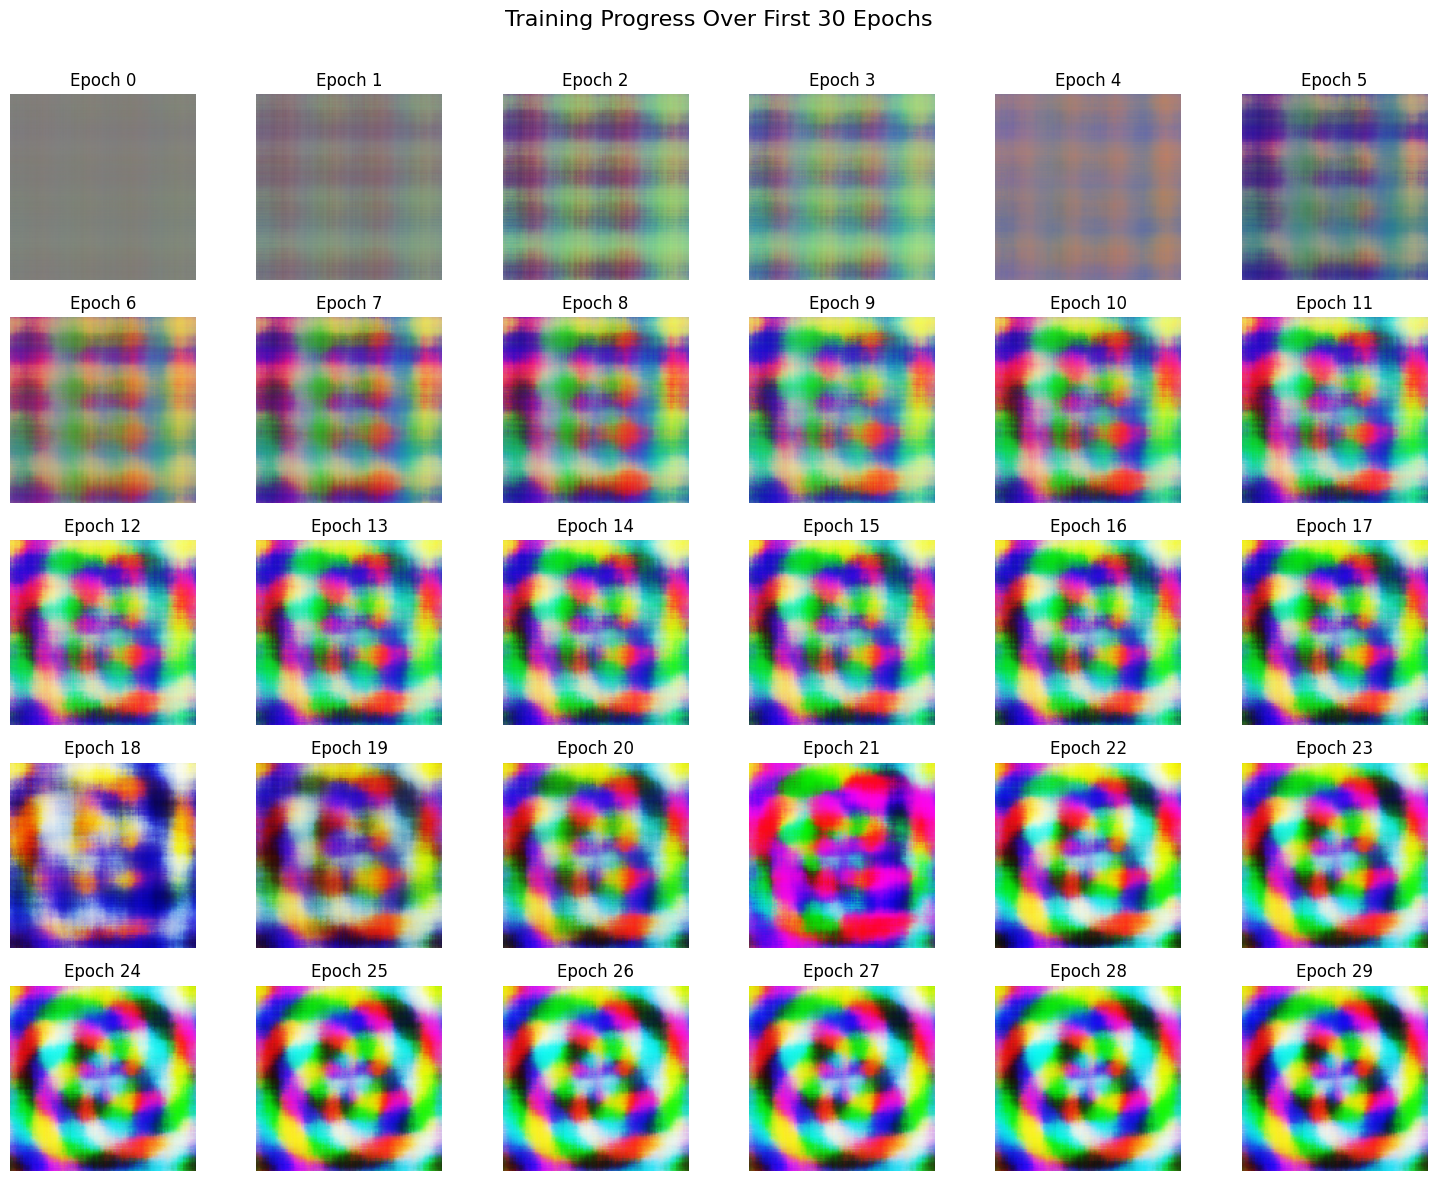

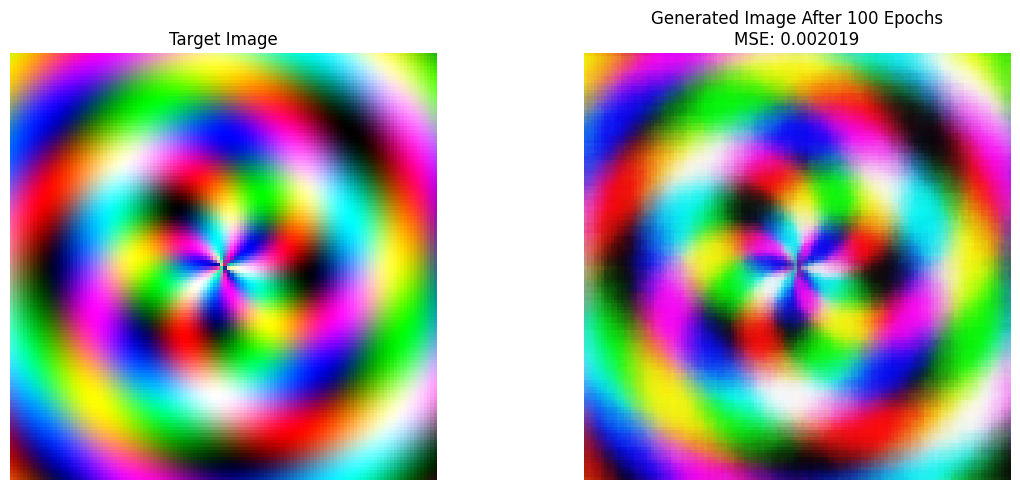

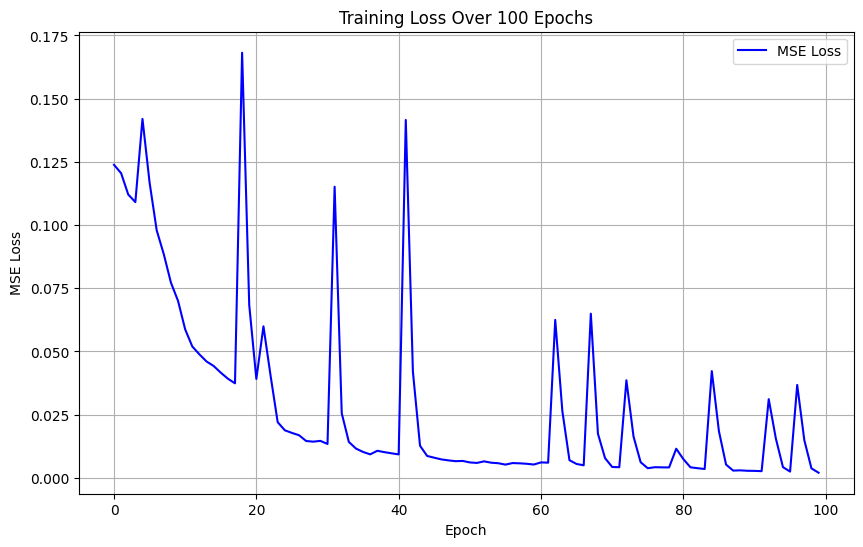

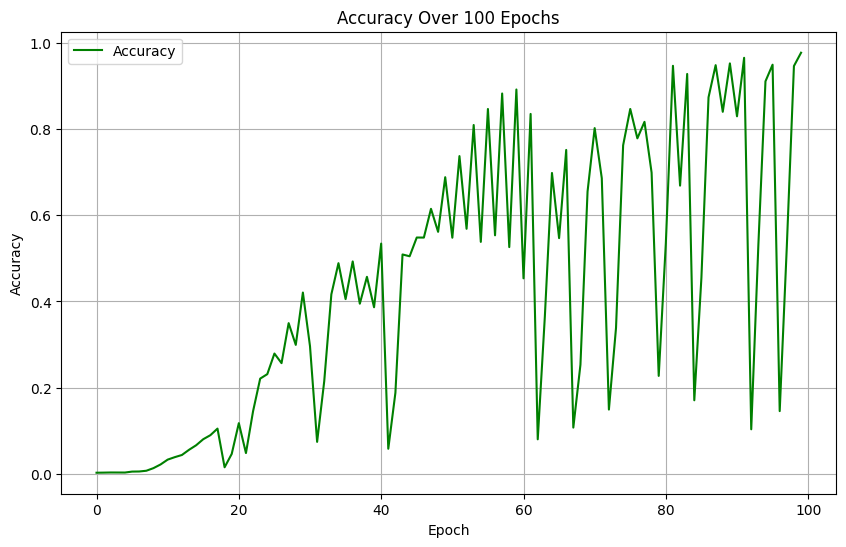

Training visualization complete!
Final MSE loss after 100 epochs: 0.002019
Generated images and plots have been saved.
GIF saved as images/training_progress.gif


/tmp/ipykernel_20506/2973312066.py:94: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


In [10]:
import os
import imageio
import torch
import matplotlib.pyplot as plt

# -------------------------------
# Step 8. Final Visualizations and Comparisons
# -------------------------------

# Ensure the images folder exists
os.makedirs("images", exist_ok=True)

# Plot Training Progress for the First 30 Epochs
rows, cols = 5, 6
fig_grid = plt.figure(figsize=(15, 12))
plt.suptitle("Training Progress Over First 30 Epochs", fontsize=16)

for i, (epoch, img) in enumerate(generated_images):
    if i < rows * cols:
        ax = fig_grid.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(f"Epoch {epoch}")
        ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join("images", "first_30_epochs_grid.png"), dpi=300)
plt.show()

# Comparison of Target and Generated Image
plt.figure(figsize=(12, 5))
with torch.no_grad():
    final_image = model(coords_encoded).cpu().numpy().reshape(resolution, resolution, 3)

plt.subplot(1, 2, 1)
plt.imshow(target_image)
plt.title("Target Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title(f"Generated Image After {num_epochs} Epochs\nMSE: {loss_history[-1]:.6f}")
plt.axis("off")

plt.tight_layout()
plt.savefig(os.path.join("images", "comparison_after_epochs.png"), dpi=300)
plt.show()

# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(loss_history, 'b-', label='MSE Loss')
plt.title('Training Loss Over 100 Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join("images", "loss_curve_epochs.png"), dpi=300)
plt.show()

# Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(accuracy_history, 'g-', label='Accuracy')
plt.title('Accuracy Over 100 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join("images", "accuracy_curve_epochs.png"), dpi=300)
plt.show()

print("Training visualization complete!")
print(f"Final MSE loss after {num_epochs} epochs: {loss_history[-1]:.6f}")
print("Generated images and plots have been saved.")

# -------------------------------
# Step 9. Create a GIF of Training Progress
# -------------------------------

def create_progress_gif(image_folder="epoch_images", output_folder="images", gif_name="training_progress.gif", duration=0.5):
    """
    Create a GIF from the images saved for each epoch.
    
    Args:
        image_folder (str): Folder containing epoch images.
        output_folder (str): Folder to save the generated GIF.
        gif_name (str): Output filename for the GIF.
        duration (float): Duration between frames in seconds.
    """
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists
    images = []

    for epoch in range(30):  # Using the first 30 epochs for the GIF
        image_path = os.path.join(image_folder, f"epoch_{epoch:02d}.png")
        if os.path.exists(image_path):
            images.append(imageio.imread(image_path))

    gif_path = os.path.join(output_folder, gif_name)
    imageio.mimsave(gif_path, images, duration=duration)
    print(f"GIF saved as {gif_path}")

# Generate GIF
create_progress_gif()
